<a href="https://colab.research.google.com/github/Colonna17/Collision_Avoidance-Sapienza_Vision_and_Perception/blob/lapocarrieri-patch-1/notebooks/CCD_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb
import wandb
wandb.init()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 646.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 4.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=cb005248f17913db551adfe002b2443de5bf73d5886a1c8e643e444da4b11f84
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone --recurse-submodules https://github.com/Colonna17/Collision_Avoidance-Sapienza_Vision_and_Perception.git

%cd Collision_Avoidance-Sapienza_Vision_and_Perception
!./setup.sh 
# %pip install -qr external/yolov5/requirements.txt 
# %pip install -qr requirements.txt #install dependencies

Cloning into 'Collision_Avoidance-Sapienza_Vision_and_Perception'...
remote: Enumerating objects: 436, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 436 (delta 24), reused 7 (delta 5), pack-reused 396
Receiving objects: 100% (436/436), 342.02 MiB | 17.79 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Submodule 'Yolov5_StrongSORT_OSNet' (https://github.com/mikel-brostrom/Yolov5_StrongSORT_OSNet.git) registered for path 'external/Yolov5_StrongSORT_OSNet'
Submodule 'yolov5' (https://github.com/ultralytics/yolov5.git) registered for path 'external/yolov5'
Cloning into '/content/Collision_Avoidance-Sapienza_Vision_and_Perception/external/Yolov5_StrongSORT_OSNet'...
remote: Enumerating objects: 4249, done.        
remote: Counting objects: 100% (578/578), done.        
remote: Compressing objects: 100% (274/274), done.        
remote: Total 4249 (delta 347), reused 487 (delta 285), pack-reused 3671        
Receiving o

In [4]:
!pwd

/content/Collision_Avoidance-Sapienza_Vision_and_Perception


In [5]:
import os
import sys
from IPython.utils import io
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split
import torchvision
import torchvision.transforms as transforms

sys.path.append('external/yolov5')
from external.yolov5.utils.dataloaders import LoadImages
sys.path.append('external/Yolov5_StrongSORT_OSNet')
from src.utils import numpy_brg_to_rgb, custom_from_numpy
from src.tracker import Tracker


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu') # ToDo: just for the moment. risolvere problema classificatore
device

/content/Collision_Avoidance-Sapienza_Vision_and_Perception/external/Yolov5_StrongSORT_OSNet/strong_sort/deep/reid/torchreid/metrics/rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(


device(type='cuda')

In [6]:
!nvidia-smi

Tue Jan 24 17:08:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    12W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create the dataset 

In [7]:
# %cd /content/drive/MyDrive/Vision and Perception Project/Car Crash Dataset
data_dir = '/content/drive/MyDrive/Vision and Perception Project/Car Crash Dataset/videos'

# Cosa cambia?
# test_video_dir = data_dir + "/Crash-1500/"
test_video_dir = data_dir + '/Dataset/'
# test_annotation_file = data_dir + "/Crash-1500.txt"
test_annotation_file = data_dir + '/Dataset_annotations.txt'

In [8]:
!ls /content/drive/MyDrive/Vision\ and\ Perception\ Project/Car\ Crash\ Dataset/videos # data_dir

Crash-1500	Dataset			 Normal-50.txt		Test-Crash
Crash-1500.txt	Dataset_annotations.txt  Normal.zip
Crash-1500.zip	Normal-3000		 test_annontations.txt


In [9]:
# videos_directory = test_video_dir
# videos_paths = [ videos_directory + video_name for video_name in os.listdir(videos_directory) ]
# videos_paths

In [10]:
class CCDVideos(Dataset):
    def __init__(self, videos_directory, annotations_path):
        super().__init__()
        self.videos_paths = [ videos_directory + video_name for video_name in os.listdir(videos_directory) ]
        self.videos_paths.sort()
        self.annotations = self.read_annotations_file(annotations_path)

    def __getitem__(self, idx):
        video_frames = self.videos_paths[idx] # self.get_video_frames(self.videos_paths[idx])
        video_annotations = self.annotations[idx]
        return {'frames': video_frames, 'annotations': video_annotations}

    def __len__(self):
        return len(self.videos_paths)

    def read_annotations_file(self, annotations_path):
        assert os.path.exists(annotations_path), "Annotation file does not exist!" + annotations_path
        result = []
        with open(annotations_path, 'r') as f:
            for line in f.readlines():
                items = {}
                items['vid'] = line.strip().split(',[')[0]
                labels = line.strip().split(',[')[1].split('],')[0]
                items['labels'] = [int(val) for val in labels.split(',')]
                others = line.strip().split(',[')[1].split('],')[1].split(',')
                items['startframe'], items['vid_ytb'], items['lighting'], items['weather'], items['ego_involve'] = others
                result.append(items)
        f.close()
        return result
    
    @staticmethod
    def get_video_frames(video_file, topN=50):
        # get the video data
        cap = cv2.VideoCapture(video_file)
        ret, frame = cap.read() # Cos'è ret?
        
        video_data = []
        while (ret):
            video_data.append(numpy_brg_to_rgb(frame))
            ret, frame = cap.read()
        
        # Necessario?
        assert len(video_data) >= topN 
        video_data = video_data[:topN]
        
        return video_data

In [11]:
ccd_dataset = CCDVideos(test_video_dir, test_annotation_file)
# loader = DataLoader(ccd_dataset, batch_size=1) #, num_workers=0)

train_set, validation_set, test_set = random_split(ccd_dataset,[0.8, 0.1, 0.1],
                                                   generator=torch.Generator().manual_seed(38))
train_loader = DataLoader(train_set, batch_size=1) #, num_workers=0)
validation_loader = DataLoader(validation_set, batch_size=1) #, num_workers=0)
test_loader = DataLoader(test_set, batch_size=1) #, num_workers=0)

In [12]:
video_test = train_set[0]
frames_test = CCDVideos.get_video_frames(video_test['frames'])
frame0_nr = 0
frame1_nr = 10

Annotation:  0


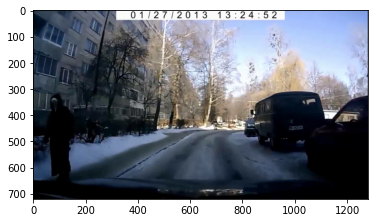

In [13]:
img0_test = frames_test[frame0_nr]
plt.imshow(img0_test)
print('Annotation: ', video_test['annotations']['labels'][frame0_nr])

Annotation:  0


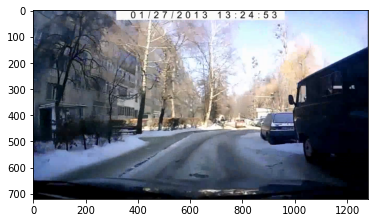

In [14]:
img1_test = frames_test[frame1_nr]
plt.imshow(img1_test)
print('Annotation: ', video_test['annotations']['labels'][frame1_nr])

# Optical Flow test (Just for fun)

In [15]:
from torchvision.utils import flow_to_image
import torchvision.transforms.functional as F

from src.opticalFlowEstimator import OpticalFlowEstimator

In [16]:
optical = OpticalFlowEstimator(device)
optical.eval()
print('')

Downloading: "https://download.pytorch.org/models/raft_small_C_T_V2-01064c6d.pth" to /root/.cache/torch/hub/checkpoints/raft_small_C_T_V2-01064c6d.pth


Frame size:  torch.Size([3, 720, 1280])
Flow size:  torch.Size([3, 720, 1280]) 



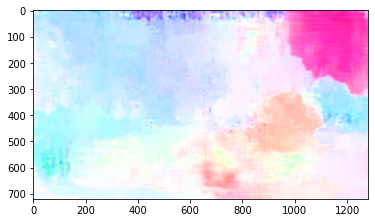

In [17]:
frame0 = torch.permute(custom_from_numpy(img0_test, device), (2,0,1)).unsqueeze(0)
frame1 = torch.permute(custom_from_numpy(img1_test, device), (2,0,1)).unsqueeze(0)

test_flow = optical(frame0, frame1)[-1]

test_flow = flow_to_image(test_flow).squeeze(0)
plt.imshow(F.to_pil_image(test_flow.to("cpu")))

print('Frame size: ', frame0.squeeze(0).shape)
print('Flow size: ', test_flow.shape, '\n')

# Hyperparameters

In [18]:
class HParams():
    # Model parameters
    img_size = (720, 1280, 3)
    lstm_hidden_dim = 32
    collision_threshold = 0.5
    
    # Training parameters
    lr = 1e-4
    num_epochs = 5
    early_stopping = True
    patience = 0

params = HParams()

# Define model settings

In [19]:
# from src.classifier import Classifier
from src.build import build
from src.utils import DEFAULT_OPTIONS

options = DEFAULT_OPTIONS

In [20]:
for key in options:
    print(key, ': ', str(options[key]))

source :  data/videos/CCD/000017.mp4
show_vid :  False
save_vid :  False
save_txt :  False
img_height :  720
img_width :  1280
yolo_weights :  weights/yolov5s.pt
classes :  [0, 1, 2, 3, 5, 7, 9, 11]
conf_thres :  0.25
max_det :  150
yolo_img_height :  640
yolo_img_width :  640
strong_sort_weights :  weights/osnet_x0_25_msmt17.pt
lstm_hidden_dim :  8


In [21]:
# Change options here:


# Model loading

In [22]:
yolo, tracker, classifier = build(device, options)

INFO:yolov5:Fusing layers... 
Fusing layers... 
Fusing layers... 
Fusing layers... 
INFO:yolov5:YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Successfully loaded pretrained weights from "weights/osnet_x0_25_msmt17.pt"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


# Classifier Training


In [23]:
optim = torch.optim.Adam(classifier.parameters(), lr=params.lr)

In [24]:
def train(model, optimizer, train_dataset, valid_dataset, device, options, yolo, tracker, hparams):
    torch.cuda.empty_cache()
    train_history = []
    valid_history = []
    yolo_scaled_img_size = (options['yolo_img_height'], options['yolo_img_width'])
    patience = hparams.patience

    for epoch in range(hparams.num_epochs):
        print('Epoch {:03d}:'.format(epoch + 1))

        epoch_loss = 0.0
        model.train() 

        for step, video in enumerate(train_dataset):
            print('\r\t[training] Video nr: ', step, end=' ')
            frames_path = video['frames']
            frames = LoadImages(frames_path, img_size=yolo_scaled_img_size, stride=yolo.model.stride, auto=yolo.model.pt)
            labels = torch.FloatTensor(video['annotations']['labels'][1:]).to(device)
            
            # Tracker reset (suppressing the print)
            with io.capture_output() as captured:
                tracker = Tracker(device, options)

            optimizer.zero_grad()
            predictions = []
            curr_frame, prev_frame = None, None
            h = None
            for frame_idx, (path, img_scaled, img, vid_cap, s) in enumerate(frames):
                curr_frame = img.copy()
                curr_frame_scaled = custom_from_numpy(img_scaled, device).unsqueeze(0)

                yolo_detections = yolo.detect(curr_frame_scaled)
                tracking_output = tracker.track(curr_frame, prev_frame, yolo_detections, curr_frame_scaled.shape[2:])
                
                if(frame_idx > 1): 
                    pred, h = classifier(curr_frame, prev_frame, tracking_output, h)
                elif(frame_idx == 1): 
                    pred, h = classifier(curr_frame, prev_frame, tracking_output)
                else: 
                    prev_frame = curr_frame
                    continue
                    
                predictions.append(pred) 
                prev_frame = curr_frame

            predictions = torch.cat(predictions, 0).squeeze(1)

            sample_loss = model.loss(predictions, labels)
            sample_loss.backward()
            optimizer.step()
            epoch_loss += sample_loss.item()
        
        avg_epoch_loss = epoch_loss / len(train_dataset)
        train_history.append(avg_epoch_loss)
        print('\r\tTrain loss = {:0.4f}'.format(avg_epoch_loss))
        torch.cuda.empty_cache()

        avg_valid_loss = evaluate(model, valid_dataset, yolo, device, options)
        valid_history.append(avg_valid_loss)
        print('\tValid loss = {:0.4f}'.format(avg_valid_loss))
        if hparams.early_stopping:
            stop = epoch > 0 and valid_history[-1] > valid_history[-2]
            if stop:
                if patience <= 0:
                    print('\tEarly stop.')
                    break
                else:
                    print('\tPatience.')
                    patience -= 1
    
    print('Done!')

    return {'train_history': train_history, 'valid_history': valid_history}


In [25]:
def evaluate(model, dataset, yolo, device, options):
    loss = 0.0
    model.eval()
    yolo_scaled_img_size = (options['yolo_img_height'], options['yolo_img_width'])
    with torch.no_grad():
        for step, video in enumerate(dataset):
            print('\r\t[evaluation] Video nr: ', step, end=' ')

            # Tracker reset (suppressing the print)
            with io.capture_output() as captured:
                tracker = Tracker(device, options)

            frames_path = video['frames']
            frames = LoadImages(frames_path, img_size=yolo_scaled_img_size, stride=yolo.model.stride, auto=yolo.model.pt)
            labels = torch.FloatTensor(video['annotations']['labels'][1:]).to(device)
            
            predictions = []
            curr_frame, prev_frame = None, None
            h = None
            for frame_idx, (path, img_scaled, img, vid_cap, s) in enumerate(frames):
                curr_frame = img.copy()
                curr_frame_scaled = custom_from_numpy(img_scaled, device).unsqueeze(0)
                yolo_detections = yolo.detect(curr_frame_scaled)
                tracking_output = tracker.track(curr_frame, prev_frame, yolo_detections, curr_frame_scaled.shape[2:])
                if(frame_idx > 1): 
                    pred, h = classifier(curr_frame, prev_frame, tracking_output, h)
                elif(frame_idx == 1): 
                    pred, h = classifier(curr_frame, prev_frame, tracking_output)
                else: 
                    prev_frame = curr_frame
                    continue
                predictions.append(pred) 
                prev_frame = curr_frame
            predictions = torch.cat(predictions, 0).squeeze(1)

            sample_loss = model.loss(predictions, labels)
            loss += sample_loss.item()
    torch.cuda.empty_cache()
    return loss / len(dataset)


In [26]:
torch.cuda.empty_cache()
logs = train(classifier, optim, train_set, validation_set, device, options, yolo, tracker, params)

Epoch 001:
	Train loss = 0.7491
	[evaluation] Video nr:  9 	Valid loss = 0.7164
Epoch 002:
	Train loss = 0.7278
	[evaluation] Video nr:  9 	Valid loss = 0.7331
	Early stop.
Done!


In [27]:
# In order to free some memory
classifier.eval()
optim.zero_grad()
torch.cuda.empty_cache()

In [29]:
weights_name = "Crash_Classfier_weights_5.pt"
torch.save(classifier.state_dict(), "/content/drive/MyDrive/Vision and Perception Project/Classifier_weights2/" + weights_name)

 # just to be sure:
torch.save(classifier.state_dict(), "/content/drive/MyDrive/Vision and Perception Project/Classifier_weights_all_2/" + weights_name)

In [30]:
def plot_training_logs(logs, title, out_img_name):
    plt.figure(figsize=(15,10))

    plt.plot(list(range(len(logs['train_history']))), logs['train_history'], label='Train loss')
    # plt.plot(list(range(len(logs['valid_history']))), logs['valid_history'], label='Valid loss')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")
    plt.savefig(out_img_name)
    plt.show()

In [31]:
logs

{'train_history': [0.7490883857011795, 0.7277559854090214],
 'valid_history': [0.716400408744812, 0.7330649018287658]}

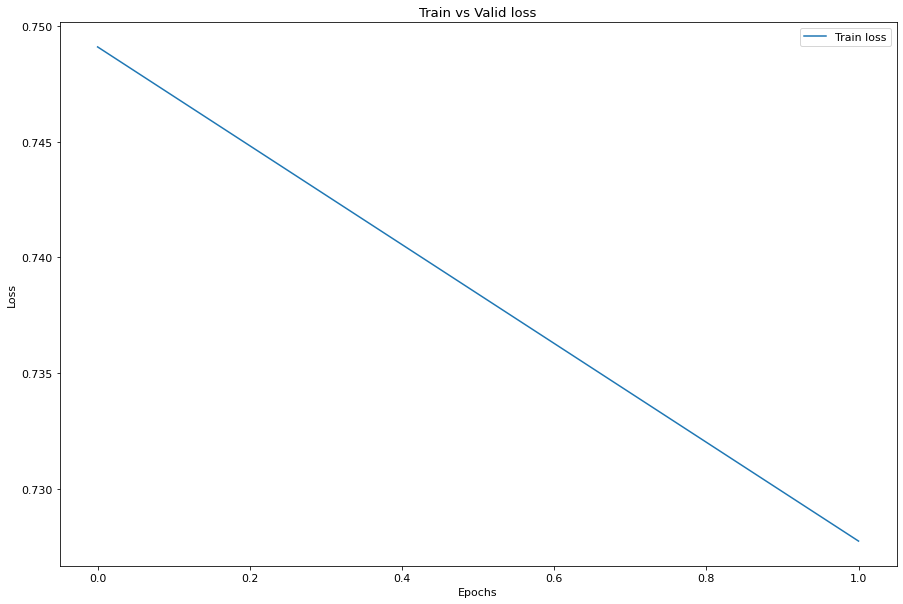

In [32]:
plot_training_logs(logs, 'Train vs Valid loss', 'loss_plot.png')

# Testing

In [ ]:
final_loss = evaluate(classifier, test_set, yolo, device, options)
print('Final loss: ', final_loss)

	[evaluation] Video nr:  7 